In [6]:
# Import necessary libraries
import pandas as pd
import pmdarima as pmd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
# For statistical tests and models
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA 
# For model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

In [11]:
#import Tempreture data
df = pd.read_csv('../data/clean_SSTEMP_sensor.csv')

# Data Preproccesing

In [12]:
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
df.sort_index(inplace=True)
df.head(-10)

,State,Device,Unit
Time,,,
2024-09-12 01:04:03,13.000000,SSTEMP_sensor,C
2024-09-12 01:04:28,12.900000,SSTEMP_sensor,C
2024-09-12 01:04:53,12.900000,SSTEMP_sensor,C
2024-09-12 01:05:18,12.900000,SSTEMP_sensor,C
2024-09-12 01:05:43,12.900000,SSTEMP_sensor,C
...,...,...,...
2024-09-13 21:08:51,13.200403,SSTEMP_sensor,C
2024-09-13 21:09:16,13.200403,SSTEMP_sensor,C
2024-09-13 21:09:41,13.224087,SSTEMP_sensor,C


Data points are 25 seconds apart

No missing values

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6216 entries, 2024-09-12 01:04:03 to 2024-09-13 21:14:41
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   6216 non-null   float64
 1   Device  6216 non-null   object 
 2   Unit    6216 non-null   object 
dtypes: float64(1), object(2)
memory usage: 194.2+ KB


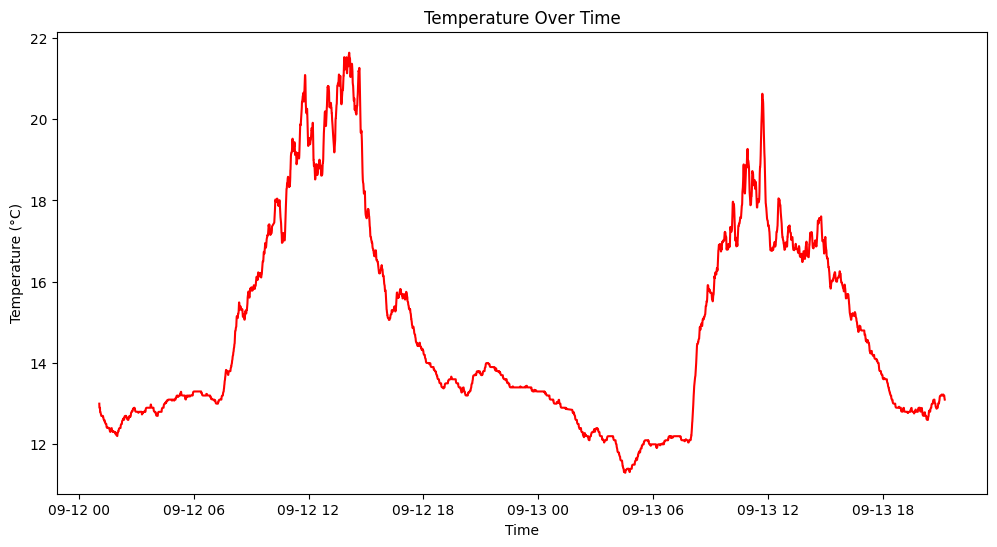

In [32]:
# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(df['State'], color='red')
plt.title('Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

In [23]:
# Define forecast horizon in steps (30 minutes = 72 steps of 25 seconds)
forecast_horizon = 72

# Define train size: leave out the last 'forecast_horizon' observations for testing
train_size = len(df) - forecast_horizon
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

In [24]:
model = pmd.auto_arima(train_data['State'], seasonal=False,
                       trace=True, error_action='ignore',
                       suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-28275.103, Time=2.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23619.758, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28264.994, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-26640.493, Time=2.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23621.758, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-28276.701, Time=1.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-27649.808, Time=8.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-28266.357, Time=0.82 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-28276.516, Time=11.68 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-28080.125, Time=5.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-28261.331, Time=6.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-28271.045, Time=5.61 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-28278.700, Time=2.92 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-27651.807, Time=2.48 sec
 ARI

In [25]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6144
Model:               SARIMAX(1, 1, 2)   Log Likelihood               14143.350
Date:                Fri, 20 Sep 2024   AIC                         -28278.700
Time:                        10:36:34   BIC                         -28251.808
Sample:                             0   HQIC                        -28269.372
                               - 6144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6727      0.010     68.879      0.000       0.654       0.692
ma.L1          0.0733      0.012      6.222      0.000       0.050       0.096
ma.L2          0.0631      0.010      6.072      0.0

In [26]:
# Predict the next 72 steps (30 minutes ahead)
forecast, conf_int = model.predict(n_periods=forecast_horizon, return_conf_int=True)

C:\Users\tiaan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\tiaan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [27]:
# Actual values from the test set
actual = test_data['State'].iloc[:forecast_horizon].values

# Predicted values
predicted = forecast

# Calculate error metrics
mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.024179615328004014
Mean Absolute Error: 0.1374468434317266


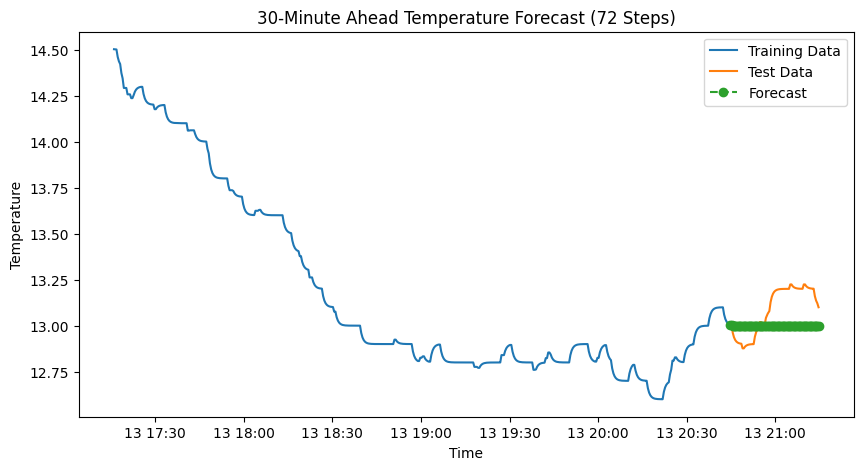

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(train_data.index[-500:], train_data['State'][-500:], label='Training Data')  # Last 500 points of training
plt.plot(test_data.index[:forecast_horizon], test_data['State'][:forecast_horizon], label='Test Data')
plt.plot(test_data.index[:forecast_horizon], forecast, label='Forecast', marker='o', linestyle='--')

plt.title('30-Minute Ahead Temperature Forecast (72 Steps)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


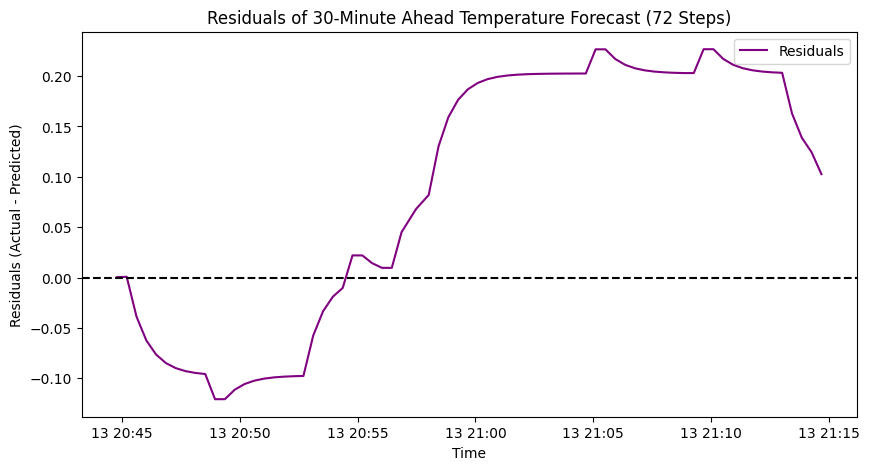

In [34]:
actual = test_data['State'][:forecast_horizon].values
predicted = forecast[:forecast_horizon]

# Calculate residuals
residuals = actual - predicted
plt.figure(figsize=(10, 5))
plt.plot(test_data.index[:forecast_horizon], residuals, label='Residuals', color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals of 30-Minute Ahead Temperature Forecast (72 Steps)')
plt.xlabel('Time')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()